# 1. Libraries & Sample Data
The first step is to load our Python Libraries and download the sample data. The dataset represents Apple stock price (1d bars) for the year 2010

In [103]:
# Load Python Libraries
import math
import keras
import random
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from tqdm.notebook import tqdm
from collections import deque
from IPython.display import display, HTML
from sklearn.preprocessing import StandardScaler

# for dataframe display
pd.set_option('display.max_rows', None)
def display_df(df):
    # Puts the scrollbar next to the DataFrame
    display(HTML("<div style='height: 200px; overflow: auto; width: fit-content'>" + df.to_html() + "</div>"))

# for reproducability of training rounds
keras.utils.set_random_seed(42)

# 2. Exploratory Data Analysis
Next, we want to analyze our data. Display the data as a dataframe, and plot some relevant data so you can get an idea of what our dataset looks like.

In [104]:
# Download Sample Data
data = pd.read_csv('GOOG_2009-2010_6m_RAW_1d.csv')

In [105]:
display_df(data.head())

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-04-01,8.562406,8.847836,8.483452,8.819193,8.819193,132542948.0
1,2009-04-02,9.048833,9.209481,8.974362,9.028658,9.028658,180192885.0
2,2009-04-03,9.078472,9.258298,8.916578,9.209979,9.209979,152160204.0
3,2009-04-06,9.140738,9.210975,9.001261,9.171623,9.171623,131703815.0
4,2009-04-07,NaN,NaN,NaN,NaN,NaN,NaN


In [106]:
# Index data by Date
data['Date'] = pd.to_datetime(data['Date'])

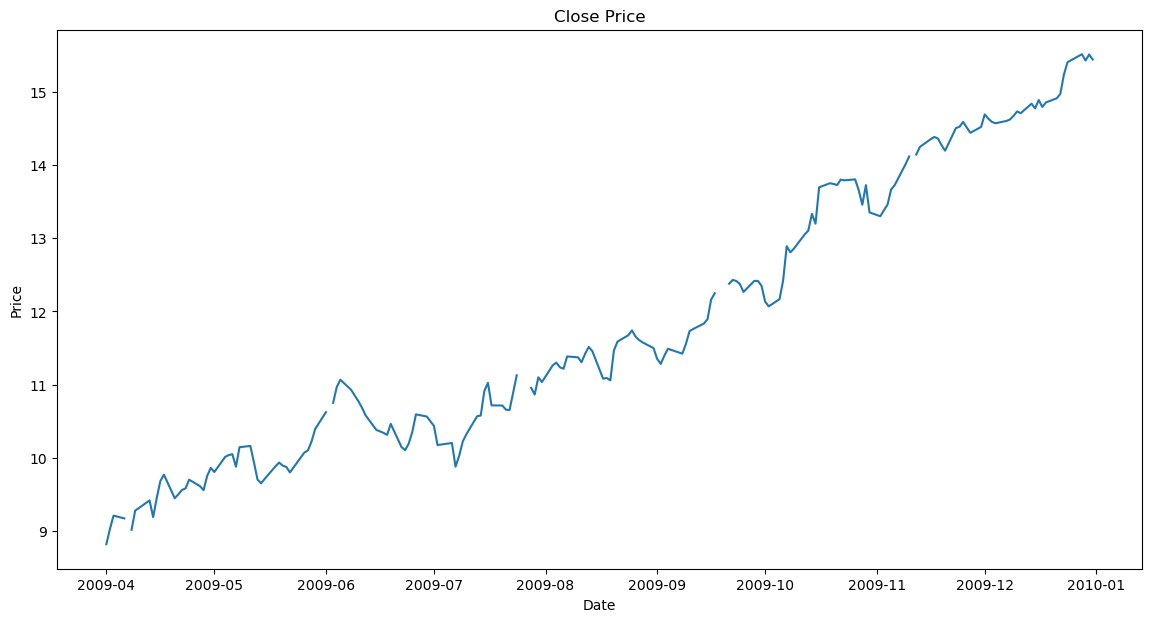

In [107]:
# Plot the Close Data
plt.figure(figsize=(14, 7))
plt.plot(data['Date'], data['Close'])
plt.title('Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# 3. Data Cleaning
Next, we need to clean our data for training our model. This requires removal of NaN values.

In [108]:
# Check for null values
data.isnull().sum()

Date         0
Open         5
High         5
Low          5
Close        5
Adj Close    5
Volume       5
dtype: int64

In [109]:
# forward fill missing values
data.ffill(inplace=True)

In [110]:
# Check for null values
data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

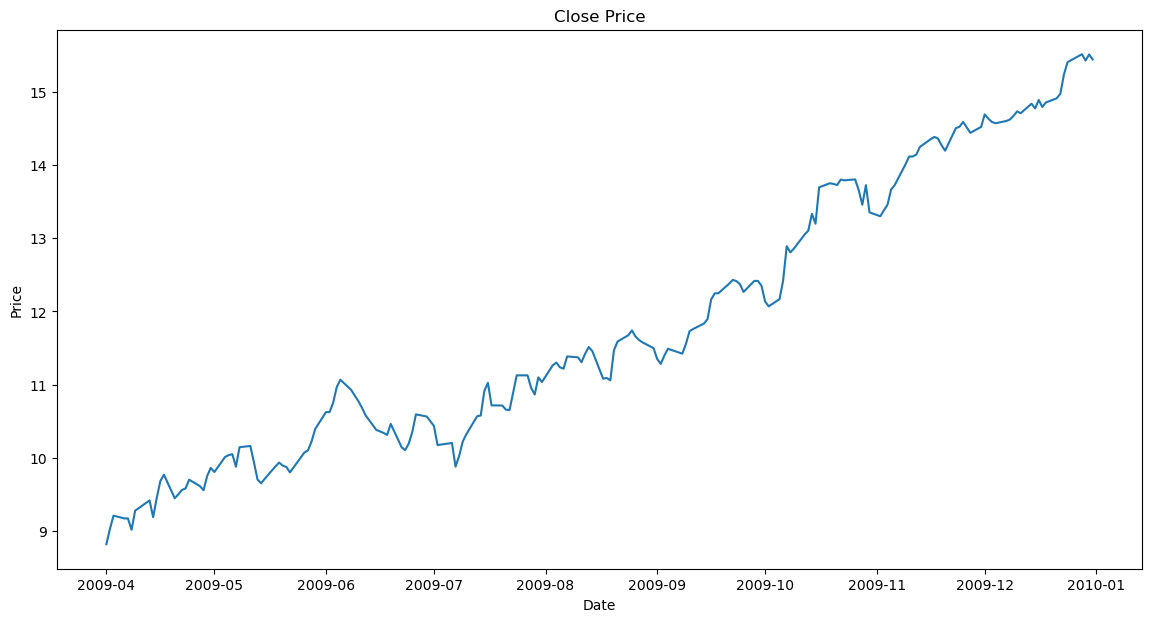

In [111]:
# Plot the cleaned Close Data
plt.figure(figsize=(14, 7))
plt.plot(data['Date'], data['Close'])
plt.title('Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# 4. Feature Selection
Now that we have cleaned our stock data, we need to select which features to train our model on. For this project, we will be training with Close data and 20-day Bollinger Bands of Close.

In [112]:
# Calculate 20-day bollinger bands
data['20_day_sma'] = data['Close'].rolling(window=20).mean()
data['20_day_std'] = data['Close'].rolling(window=20).std()
data['Upper_band'] = data['20_day_sma'] + (data['20_day_std'] * 2)
data['Lower_band'] = data['20_day_sma'] - (data['20_day_std'] * 2)


In [113]:
data.head(25)

,Date,Open,High,Low,Close,Adj Close,Volume,20_day_sma,20_day_std,Upper_band,Lower_band
0,2009-04-01,8.562406,8.847836,8.483452,8.819193,8.819193,132542948.0,NaN,NaN,NaN,NaN
1,2009-04-02,9.048833,9.209481,8.974362,9.028658,9.028658,180192885.0,NaN,NaN,NaN,NaN
2,2009-04-03,9.078472,9.258298,8.916578,9.209979,9.209979,152160204.0,NaN,NaN,NaN,NaN
3,2009-04-06,9.140738,9.210975,9.001261,9.171623,9.171623,131703815.0,NaN,NaN,NaN,NaN
4,2009-04-07,9.140738,9.210975,9.001261,9.171623,9.171623,131703815.0,NaN,NaN,NaN,NaN
5,2009-04-08,9.053565,9.090925,8.871996,9.016205,9.016205,111022586.0,NaN,NaN,NaN,NaN
6,2009-04-09,9.203005,9.323802,9.122058,9.277725,9.277725,135811153.0,NaN,NaN,NaN,NaN
7,2009-04-13,9.248584,9.442109,9.222930,9.417451,9.417451,122461301.0,NaN,NaN,NaN,NaN
8,2009-04-14,9.388310,9.389556,9.105869,9.188310,9.188310,137658049.0,NaN,NaN,NaN,NaN
9,2009-04-15,9.143229,9.490926,9.070003,9.452071,9.452071,197967259.0,NaN,NaN,NaN,NaN


In [114]:
# Remove rows with NaN bollinger bands 
data.dropna(inplace=True)

In [115]:
data.head(25)

,Date,Open,High,Low,Close,Adj Close,Volume,20_day_sma,20_day_std,Upper_band,Lower_band
19,2009-04-29,9.613217,9.837377,9.609730,9.750204,9.750204,144941247.0,9.395770,0.271027,9.937823,8.853717
20,2009-04-30,9.857053,10.056057,9.833143,9.862284,9.862284,174881049.0,9.447924,0.254066,9.956057,8.939792
21,2009-05-01,9.838871,9.902633,9.752196,9.805497,9.805497,97471985.0,9.486766,0.245844,9.978454,8.995079
22,2009-05-04,9.917078,10.022433,9.832894,10.011973,10.011973,128600225.0,9.526866,0.263121,10.053107,9.000625
23,2009-05-05,9.962159,10.087191,9.894164,10.037128,10.037128,96391952.0,9.570141,0.272622,10.115385,9.024898
24,2009-05-06,10.131774,10.168885,9.987564,10.049084,10.049084,105710750.0,9.614014,0.275700,10.165415,9.062614
25,2009-05-07,10.064775,10.086942,9.775858,9.878224,9.878224,120441759.0,9.657115,0.242734,10.142584,9.171646
26,2009-05-08,10.033641,10.214962,9.838124,10.145223,10.145223,155183494.0,9.700490,0.248804,10.198098,9.202882
27,2009-05-11,10.032396,10.261537,9.992545,10.161413,10.161413,102755715.0,9.737688,0.259638,10.256965,9.218412
28,2009-05-12,10.211973,10.236382,9.840864,9.938000,9.938000,152200354.0,9.775173,0.228385,10.231943,9.318403


In [116]:
# Define new dataframe with only the training features (Close, Upper BB, Lower BB)
dataset = data[['Close', 'Upper_band', 'Lower_band']]
dataset.head()

,Close,Upper_band,Lower_band
19,9.750204,9.937823,8.853717
20,9.862284,9.956057,8.939792
21,9.805497,9.978454,8.995079
22,10.011973,10.053107,9.000625
23,10.037128,10.115385,9.024898


# 5. Normalization
Now that we have cleaned our data, created our indicators of interest, and selected our features, we must normalize our data. For this project, we use the sklearn StandardScaler, which centers the data and normalizes to unit variance. We will not be using a rolling scaler for this project, due to the complexity of back-translating to true proce and indicator values - you can try this yourself once you have completed the project. 

In [117]:
# Display & Plot Un-normalized Dataset

In [118]:
# Normalize Dataset with StandardScaler
normlist = []
normed_dataset = pd.DataFrame(index=dataset.index)
for col in dataset.columns:
    normalizer = StandardScaler()
    column_data = dataset[col].values.reshape(-1, 1)
    # fit normalizer to column data
    normalizer.fit(column_data)
    # transform column data with the fitted normalizer, and place the transformed data column in out normed_dataset df
    normed_dataset[col] = normalizer.transform(column_data).flatten()
    # append the fitted normalizer to normlist for use later
    normlist.append(normalizer)
    


,Close,Upper_band,Lower_band
19,-1.341805,-1.450150,-1.430416
20,-1.277192,-1.439244,-1.377255
21,-1.309929,-1.425848,-1.343109
22,-1.190897,-1.381197,-1.339683
23,-1.176395,-1.343949,-1.324692


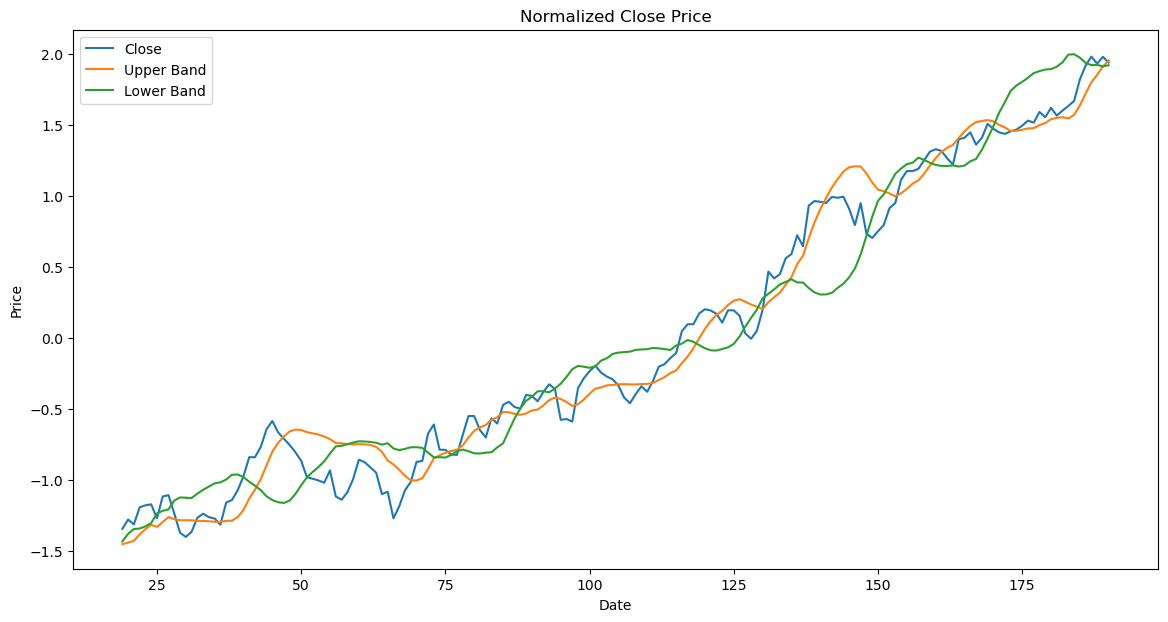

In [119]:
# Display & Plot Normalized Dataset
display_df(normed_dataset.head())
plt.figure(figsize=(14, 7))
plt.plot(normed_dataset.index, normed_dataset['Close'], label='Close')
plt.plot(normed_dataset.index, normed_dataset['Upper_band'], label='Upper Band')
plt.plot(normed_dataset.index, normed_dataset['Lower_band'], label='Lower Band')
plt.title('Normalized Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()  

# 6. Train / Test Split
Now that our data cleaned, features are selected, and the dataset is normalized, we are ready to feed the data into our model. With this in mind, we split the data ito train and test data (50/50 split)

In [120]:
# split dataset df into train (50%) and test (50%) datasets
train_df = data.loc[:int(len(data)*0.5)]
test_df =  data.loc[int(len(data)*0.5):]
train_df = train_df.reset_index(drop=True) 

In [121]:
display_df(train_df.head())
display_df(test_df.head())

,Date,Open,High,Low,Close,Adj Close,Volume,20_day_sma,20_day_std,Upper_band,Lower_band
0,2009-04-29,9.613217,9.837377,9.609730,9.750204,9.750204,144941247.0,9.395770,0.271027,9.937823,8.853717
1,2009-04-30,9.857053,10.056057,9.833143,9.862284,9.862284,174881049.0,9.447924,0.254066,9.956057,8.939792
2,2009-05-01,9.838871,9.902633,9.752196,9.805497,9.805497,97471985.0,9.486766,0.245844,9.978454,8.995079
3,2009-05-04,9.917078,10.022433,9.832894,10.011973,10.011973,128600225.0,9.526866,0.263121,10.053107,9.000625
4,2009-05-05,9.962159,10.087191,9.894164,10.037128,10.037128,96391952.0,9.570141,0.272622,10.115385,9.024898


,Date,Open,High,Low,Close,Adj Close,Volume,20_day_sma,20_day_std,Upper_band,Lower_band
86,2009-08-04,11.192299,11.307616,11.168886,11.300891,11.300891,95950302.0,10.802696,0.343938,11.490572,10.114821
87,2009-08-05,11.357430,11.380095,11.155188,11.236383,11.236383,94031136.0,10.863282,0.304088,11.471458,10.255105
88,2009-08-06,11.315088,11.329534,11.171377,11.216956,11.216956,84752487.0,10.913058,0.273428,11.459914,10.366202
89,2009-08-07,11.349210,11.442610,11.332274,11.384827,11.384827,102105287.0,10.966233,0.255090,11.476413,10.456054
90,2009-08-10,11.336010,11.417455,11.302386,11.372623,11.372623,69941178.0,11.006470,0.252403,11.511276,10.501664


# 7. Define the Agent
Now that our data is ready to use, we can define the Reinforcement Learning Agent.

### Define the DQN Model
The first step in defining our agent is the Deep Q-Network model definition. For this project, we are creating a model sequential model with four layers. The first three layers have output shape of 64, 32, and 8, respectively, and a RELU activation. The output layer has an output shape of the size of our action space (buy, sell, hold), and a linear activation. Our Loss finction is Mean Squared Error, and our optimizer is Adam with a learning rate of 0.001. Use Keras to build this model.


In [ ]:
@keras.saving.register_keras_serializable()
# Define DQN Model Architecture
class DQN(keras.Model):
     def __init__(self, state_size, action_size):

        # define model layers in keras
        model = keras.models.Sequential()

        # compile model in keras
        model.add(keras.layers.Dense(64, input_dim=state_size, activation='relu'))
        # hidden layers
        model.add(keras.layers.Dense(32, activation='relu'))
        # hidden layers
        model.add(keras.layers.Dense(8, activation='relu'))
        # output layer
        model.add(keras.layers.Dense(action_size, activation='linear'))
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse')
        # save model to DQN instance
        self.model = model


### Define Agent Class
Now that we have defined our underlying DQN Model, we must define out Reinforcement Learning Agent. The agent initialization is provided for you, you must define an act function, and an expereince replay function. As a reminder, the act function defines how our model will act (buy, hold, or sell) given a certain state. The Experience Replay function tackles catastrophic forgetting in our training process, by maintaining a memory buffer to allow training on independent / randomized minibatches of previous states. 

In [123]:
class Agent:
    def __init__(self, window_size, num_features, test_mode=False, model_name=''):
        self.window_size = window_size # How many days of historical data do we want to include in our state representation?
        self.num_features = num_features # How many training features do we have?
        self.state_size = window_size * num_features # State size includes number of training features per day, and number of lookback days 
        self.action_size = 3 # 0=hold, 1=buy, 2=sell
        self.memory = deque(maxlen=1000) # Bound memory size: once the memory reaches 1000 units, the lefthand values are discarded as righthand values are added
        self.inventory = [] # Inventory to hold trades
        self.model_name = model_name # filename for saved model checkpoint loading
        self.test_mode = test_mode # flag for testing (allows model load from checkpoint model_name)

        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        
        self.model = keras.models.load_model(model_name) if test_mode else self._model()

    #Deep Q Learning (DQL) model
    def _model(self):
        model = DQN(self.state_size, self.action_size).model
        return model
    
    # DQL Predict (with input reshaping)
    #   Input = State
    #   Output = Q-Table of action Q-Values
    def get_q_values_for_state(self, state):
        return self.model.predict(state.flatten().reshape(1, self.state_size))
    

    # DQL Fit (with input reshaping)
    #   Input = State, Target Q-Table 
    #   Output = MSE Loss between Target Q-Table and Actual Q-Table for State
    def fit_model(self, input_state, target_output):
        return self.model.fit(input_state.flatten().reshape(1, self.state_size), target_output, epochs=1, verbose=0)    
    
    # Agent Action Selector
    #   Input = State
    #   Policy = epsilon-greedy (to minimize possibility of overfitting)
    #   Intitially high epsilon = more random, epsilon decay = less random later
    #   Output = Action (0, 1, or 2)
    def act(self, state): 
        # Choose any action at random (Probablility = epsilon for training mode, 0% for testing mode)
        if not self.test_mode and random.random() <= self.epsilon:
            return random.randrange(self.action_size)
            # **select random action here**
        # Choose the action which has the highest Q-value (Probablitly = 1-epsilon for training mode, 100% for testing mode)
        q_values = self.get_q_values_for_state(state)
        # **use model to select action here - i.e. use model to assign q-values to all actions in action space (buy, sell, hold)**
        # **return the action that has the highest value from the q-value function.**
        return np.argmax(q_values[0])
 
    # Experience Replay (Learning Function)
    #   Input = Batch of (state, action, next_state) tuples
    #   Optimal Q Selection Policy = Bellman equation
    #   Important Notes = Model fitting step is in this function (fit_model)
    #                     Epsilon decay step is in this function
    #   Output = Model loss from fitting step
    def exp_replay(self, batch_size):
        losses = []
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size + 1, l):
            mini_batch.append(self.memory[i])
            
        for state, action, reward, next_state, done in mini_batch:
            # reminders: 
            #   - state is a vector containing close & MA values for the current time step
            #   - action is an integer representing the action taken by the act function at the current time step- buy, hold, or sell
            #   - reward represents the profit of a given action - it is either 0 (for buy, hold, and sells which loose money) or the profit in dollars (for a profitable sell)
            #   - next_state is a vector containing close & MA values for the next time step
            #   - done is a boolean flag representing whether or not we are in the last iteration of a training episode (i.e. True when next_state does not exist.)
            
            if done:
                # special condition for last training epoch in batch (no next_state)
                optimal_q_for_action = reward  
            else:
                # target Q-value is updated using the Bellman equation: reward + gamma * max(predicted Q-value of next state)
                optimal_q_for_action = reward + self.gamma * np.max(self.get_q_values_for_state(next_state))
            # Get the predicted Q-values of the current state
            target_q_table = self.get_q_values_for_state(state)
            # Update the output Q table - replace the predicted Q value for action with the target Q value for action 
            target_q_table[0][action] = optimal_q_for_action
            # Fit the model where state is X and target_q_table is Y
            history = self.fit_model(state, target_q_table)
            losses += history.history['loss']

        # define epsilon decay (for the act function)     
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return losses


### Helper Functions
Before we define the training loop, we will write some helper functions: one for printing price data, one to define the sigmoid funtion, one to grab the state representation,  one to plot the trading output of our trained model, and one to plot the training loss. The printing, sigmoid, and plotting functions are defined for you. You must define the function which gets the state representation.

# 8. Train the Agent
Now that our data is ready and our agent is defined, we are ready to train the agent. 

### Helper Functions
Before we define the training loop, we will write some helper functions: one for printing price data, one to define the sigmoid funtion, one to grab the state representation,  one to plot the trading output of our trained model, and one to plot the training loss. The printing, sigmoid, and plotting functions are defined for you. You must define the function which gets the state representation.

In [124]:
# Format price string
def format_price(n):
    return ('-$' if n < 0 else '$') + '{0:.2f}'.format(abs(n))

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

# Plot behavior of trade output
def plot_behavior(data_input, bb_upper_data, bb_lower_data, states_buy, states_sell, profit, train=True):
    fig = plt.figure(figsize = (15,5))
    plt.plot(data_input, color='k', lw=2., label= 'Close Price')
    plt.plot(bb_upper_data, color='b', lw=2., label = 'Bollinger Bands')
    plt.plot(bb_lower_data, color='b', lw=2.)
    plt.plot(data_input, '^', markersize=10, color='r', label = 'Buying signal', markevery = states_buy)
    plt.plot(data_input, 'v', markersize=10, color='g', label = 'Selling signal', markevery = states_sell)
    plt.title('Total gains: %f'%(profit))
    plt.legend()
    if train:
        plt.xticks(range(0, len(train_df.index.values), int(len(train_df.index.values)/15)), train_df.index.values[0:: int(len(train_df.index.values)/15)], rotation=45, fontsize='small')
    else:
        plt.xticks(range(0, len(test_df.index.values), int(len(test_df.index.values)/15)), test_df.index.values[0::int(len(test_df.index.values)/15)], rotation=45, fontsize='small')
    plt.show()

# Plot training loss
def plot_losses(losses, title):
    plt.plot(losses)
    plt.title(title)
    plt.ylabel('MSE Loss Value')
    plt.xlabel('batch')
    plt.show()

# returns an an n-day state representation ending at time t
def get_state(data, t, n):
    # Define the features to use (only those the agent expects)
    features = ['Close', 'Upper_band', 'Lower_band']
    n_features = len(features)
    
    # Initialize an empty list to hold the window data
    window_data = []
    
    # Compute the start index for the window; if t is too small, start at 0
    start = t - n + 1
    if start < 0:
        start = 0
    
    # Collect data for each day in the window
    for i in range(start, t + 1):
        # Use only the specified features
        row = data.loc[i, features].values.astype(float)
        # Apply sigmoid to each value
        row = 1 / (1 + np.exp(-row))
        window_data.append(row)
    
    # If the window is smaller than n, pad at the beginning with the first row’s features
    while len(window_data) < n:
        first_row = data.loc[0, features].values.astype(float)
        first_row = 1 / (1 + np.exp(-first_row))
        window_data.insert(0, first_row)
    
    # Flatten the window into a 1D array
    state = np.array(window_data).flatten()
    return state

In [125]:
keras.utils.disable_interactive_logging()  # disable built-in keras loading bars - they make the output difficult to read and monitor

window_size = 1

agent = Agent(window_size, len(normed_dataset.columns), test_mode=False, model_name='dqn_model.h5')

/opt/anaconda3/envs/deeplearning/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [126]:
num_episodes = 100

### Training Loop

Running episode 0/2:   0%|          | 0/67 [00:00<?, ?it/s]

Buy: $29.44
Sell: $29.51 | Profit: $0.06
Buy: $29.70
Sell: $29.32 | Profit: -$0.39
Buy: $28.93
Buy: $29.31
Buy: $29.24
Buy: $29.21
Sell: $29.55 | Profit: $0.62
Buy: $29.60
Buy: $29.81
Sell: $30.10 | Profit: $0.79
Buy: $30.51
Sell: $30.51 | Profit: $1.27
Sell: $30.73 | Profit: $1.52
Buy: $31.10
Buy: $31.03
Sell: $30.90 | Profit: $1.30
Sell: $30.43 | Profit: $0.62
Sell: $30.08 | Profit: -$0.42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/steppSell: $30.05 | Profit: -$1.05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepSell: $30.01 | Profit: -$1.02
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/steppBuy: $29.97
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/steppSell: $30.23 | Profit: $0.26
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepBuy: $30.04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/steppSell: $30.40 | Profit: $0.36
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/steppBuy: $30.29
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/stepBuy: $30.18
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/steppSell: $29.73 | Profit: -$0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/stepBuy: $29.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

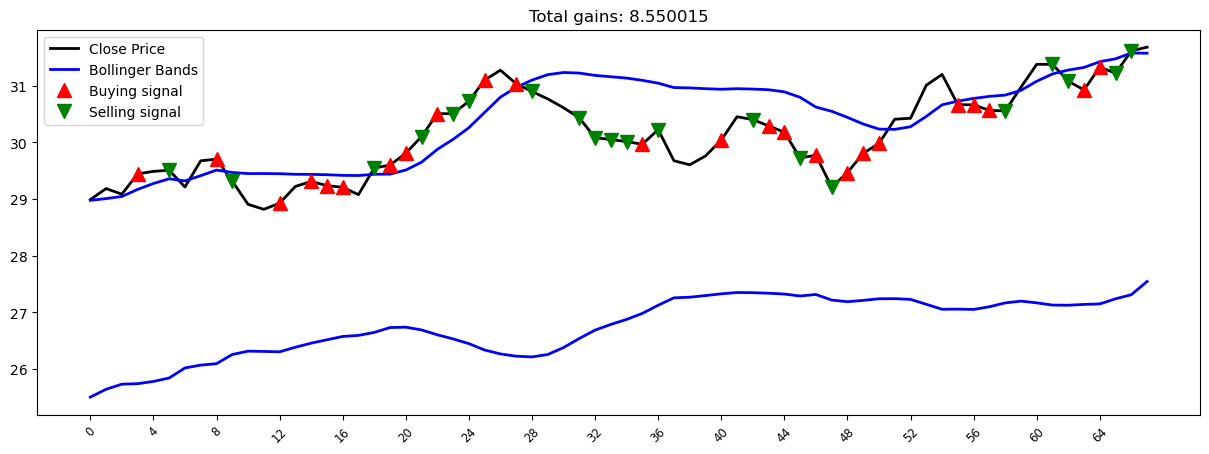

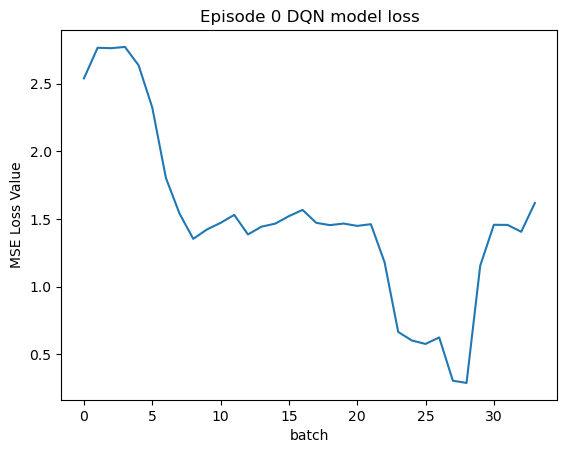

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/stepp

Running episode 1/2:   0%|          | 0/67 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/steppBuy: $29.32
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/steppBuy: $28.91
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/stepSell: $28.82 | Profit: -$0.50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/steppSell: $28.93 | Profit: $0.02
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/stepBuy: $29.21
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/steppSell: $29.08 | Profit: -$0.13
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/steppBuy: $29.81
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/stepSell: $30.10 | Profit: $0.30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/steppBuy: $30.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/steppBuy: $30.08
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/steppSell: $30.05 | Profit: -$0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/stepSell: $29.97 | Profit: -$0.12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/steppBuy: $30.04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/stepSell: $30.40 | Profit: $0.36
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/steppBuy: $29.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/stepBuy: $29.81
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/steppSell: $29.98 | Profit: $0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

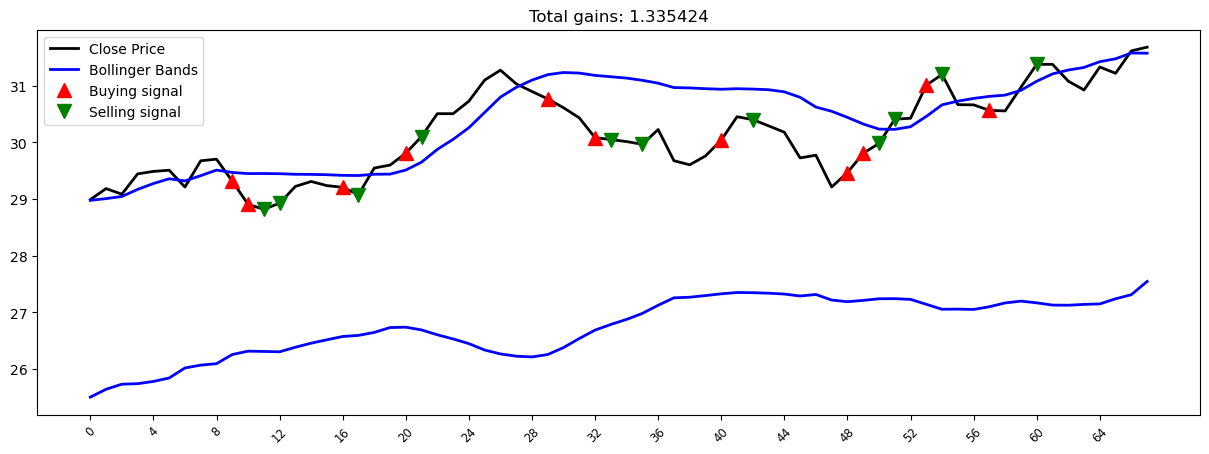

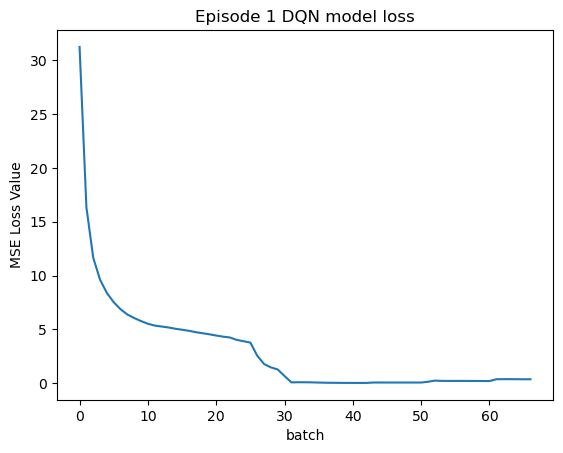

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/stepp

Running episode 2/2:   0%|          | 0/67 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/steppBuy: $29.19
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/steppBuy: $29.09
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/stepSell: $29.44 | Profit: $0.26
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/steppSell: $29.51 | Profit: $0.42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/steppBuy: $29.21
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepSell: $29.68 | Profit: $0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/stepBuy: $30.90
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/stepBuy: $30.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/steppSell: $30.61 | Profit: -$0.29
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/steppBuy: $30.43
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepSell: $30.08 | Profit: -$0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/steppSell: $30.05 | Profit: -$0.38
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/steppBuy: $29.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/steppBuy: $30.04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/stepBuy: $30.45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/steppSell: $30.40 | Profit: $0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/steppSell: $30.18 | Profit: $0.14
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

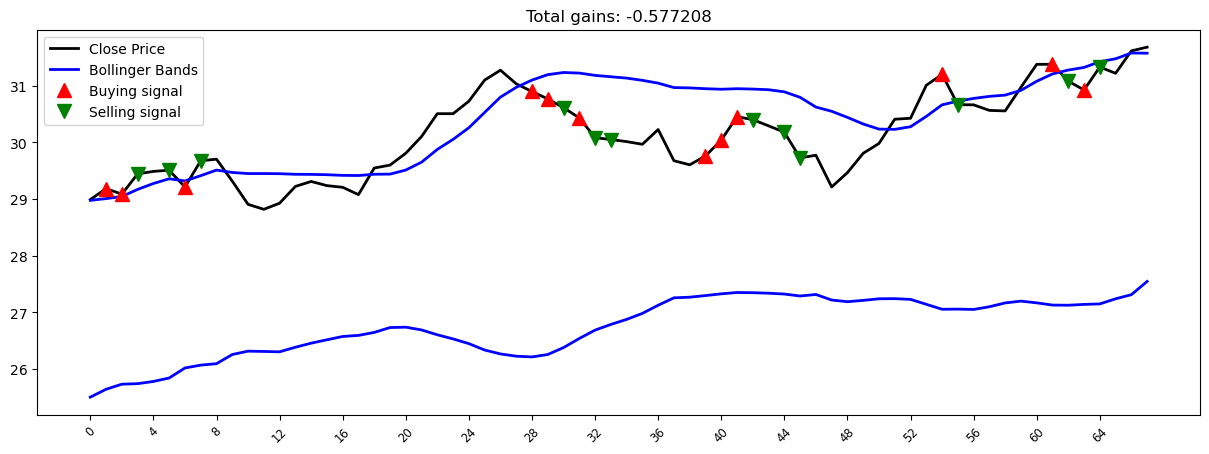

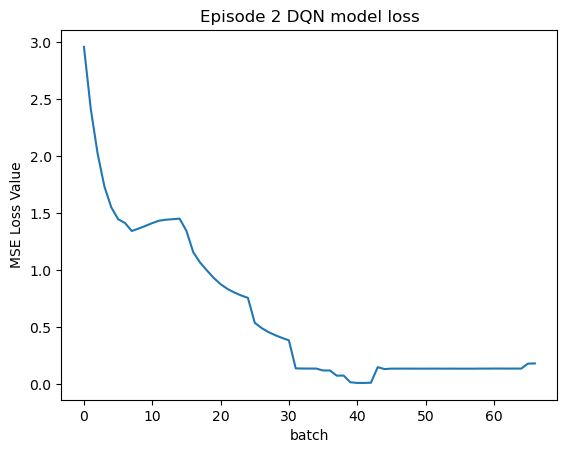

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/stepp

In [127]:
from tqdm.notebook import tqdm

keras.config.disable_traceback_filtering() # disable built-in keras loading bars - they make the output difficult to read and monitor


# Ensure the column is not causing issues by converting it to a numerical format if necessary
train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df['Date'] = train_df['Date'].map(pd.Timestamp.timestamp)

# Use the DataFrame's row count instead of slicing with [:,0]
l = train_df.shape[0] - 1
 #'Date' column is not causing issues by converting it to a numerical format if necessary
train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df['Date'] = train_df['Date'].map(pd.Timestamp.timestamp)

# Use the DataFrame's row count instead of slicing with [:,0]
l = train_df.shape[0] - 1
batch_size = 32

# An episode represents a complete pass over the data.
episode_count = 2

# Retrieve normalizers from the normlist (assumes normlist was created earlier)
normalizer_close = normlist[0]
normalizer_bb_upper = normlist[1]
normalizer_bb_lower = normlist[2]

# Inverse transform the training DataFrame values to get true (dollar) prices
X_train_true_price = normalizer_close.inverse_transform(train_df[['Close']].values)
X_train_true_bb_upper = normalizer_bb_upper.inverse_transform(train_df[['Upper_band']].values)
X_train_true_bb_lower = normalizer_bb_lower.inverse_transform(train_df[['Lower_band']].values)

batch_losses = []
num_batches_trained = 0

for e in range(episode_count + 1):
    # Use the same window_size as used in state construction
    state = get_state(train_df, 0, window_size )
    
    # initialize variables
    total_profit = 0
    total_winners = 0
    total_losers = 0
    agent.inventory = []
    states_sell = []
    states_buy = []
    
    for t in tqdm(range(l), desc=f'Running episode {e}/{episode_count}'):
        action = agent.act(state)
        next_state = get_state(train_df, t + 1, window_size)

        # initialize reward for the current time step
        reward = 0

        if action == 1:  # BUY action
            # Retrieve true buy price from the inverse-transformed array
            buy_price = X_train_true_price[t, 0]
            agent.inventory.append(buy_price)
            states_buy.append(t)
            print(f'Buy: {format_price(buy_price)}')

        elif action == 2 and len(agent.inventory) > 0:  # SELL action
            bought_price = agent.inventory.pop(0)
            # Retrieve true sell price from the inverse-transformed array
            sell_price = X_train_true_price[t, 0]

            # Calculate profit and reward
            trade_profit = sell_price - bought_price
            reward = max(trade_profit, 0)
            total_profit += trade_profit
            if trade_profit >= 0:
                total_winners += trade_profit
            else:
                total_losers += trade_profit
            states_sell.append(t)
            print(f'Sell: {format_price(sell_price)} | Profit: {format_price(trade_profit)}')

        # flag for final training iteration
        done = (t == l - 1)
        
        # Append experience to memory
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state

        # When the episode ends, print summary and plot behavior
        if done:
            print('--------------------------------')
            print(f'Episode {e}')
            print(f'Total Profit: {format_price(total_profit)}')
            print(f'Total Winners: {format_price(total_winners)}')
            print(f'Total Losers: {format_price(total_losers)}')
            if batch_losses[num_batches_trained:]:
                print(f'Max Loss: {max(batch_losses[num_batches_trained:])}')
                print(f'Total Loss: {sum(batch_losses[num_batches_trained:])}')
            print('--------------------------------')
            plot_behavior(
                X_train_true_price.flatten(),
                X_train_true_bb_upper.flatten(),
                X_train_true_bb_lower.flatten(),
                states_buy, states_sell, total_profit
            )
            plot_losses(batch_losses[num_batches_trained:], f'Episode {e} DQN model loss')
            num_batches_trained = len(batch_losses)

        if len(agent.memory) > batch_size:
            # Run experience replay when memory exceeds the batch size
            losses = agent.exp_replay(batch_size)
            batch_losses.append(sum(losses))

    # Save the model after each episode
    agent.model.save(f'model_ep{e}.keras')
